In [600]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter

In [601]:
data = pd.read_csv('GS1_ready_for_analysis.csv')

In [602]:
#looking at the columns
data.columns[0:35]

Index(['Unnamed: 0', 'Field Location', 'Source', 'PLOT ID', 'Genotype', 'Rep',
       'Plant Number', 'Trt', 'Growth Stage', 'SPADmeter', 'Ambient Humidity',
       'Ambient Pressure', 'Ambient Temperature', 'FmPrime', 'FoPrime', 'Fs',
       'FvP_over_FmP', 'Leaf Temperature', 'Leaf Temperature Differential',
       'leaf_thickness', 'LEF', 'NPQt', 'Phi2', 'PhiNO', 'PhiNPQ',
       'PS1 Active Centers', 'PS1 Open Centers', 'PS1 Over Reduced Centers',
       'PS1 Oxidized Centers', 'qL', 'SPAD_multispeq', 'vH+', 'Fresh Weight',
       'Leaf Area', '350'],
      dtype='object')

In [603]:
data.head()

,Unnamed: 0,Field Location,Source,PLOT ID,Genotype,Rep,Plant Number,Trt,Growth Stage,SPADmeter,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0,HIPS,field,4104,PHJ40 x LH82,1,1,LN,1.0,NaN,...,0.062700,0.062171,0.061800,0.061500,0.061125,0.060867,0.060542,0.060100,0.059867,0.0600
1,1,HIPS,GH,4104,PHJ40 x LH82,1,1,LN,1.0,43.566667,...,0.062700,0.062171,0.061800,0.061500,0.061125,0.060867,0.060542,0.060100,0.059867,0.0600
2,2,HIPS,field,4104,PHJ40 x LH82,1,2,LN,1.0,NaN,...,0.072433,0.072067,0.071808,0.071633,0.071400,0.071200,0.070867,0.070270,0.069833,0.0693
3,3,HIPS,GH,4104,PHJ40 x LH82,1,2,LN,1.0,49.500000,...,0.072433,0.072067,0.071808,0.071633,0.071400,0.071200,0.070867,0.070270,0.069833,0.0693
4,4,HIPS,field,4106,2FACC x 3IIH6,1,1,LN,1.0,NaN,...,0.054533,0.054333,0.054086,0.053700,0.053433,0.053167,0.052833,0.052533,0.052233,0.0518


In [604]:
data = data.loc[data['Source'] == 'GH', :]

In [605]:
sam_spectrum = data.loc[data['Field Location'] == 'SAM', :] #.iloc[: , data.columns.get_loc('350'): data.columns.get_loc('2500') +1]

In [606]:
sam_spectrum = sam_spectrum.iloc[: , sam_spectrum.columns.get_loc('350'): sam_spectrum.columns.get_loc('2500') + 1]

In [607]:
hips_spectrum = data.loc[data['Field Location'] == 'HIPS', :].iloc[: , data.columns.get_loc('350'): data.columns.get_loc('2500') +1]

Text(0, 0.5, 'Reflectance')

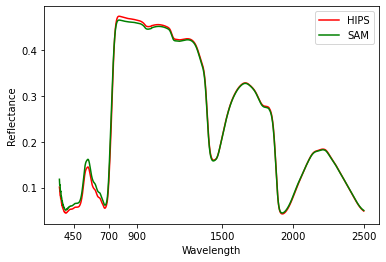

In [608]:
plt.plot(hips_spectrum.mean().T, color= 'r', label= 'HIPS')
plt.plot(sam_spectrum.mean().T, color= 'g', label = 'SAM')
plt.legend()
plt.xticks(ticks=['450', '700', '900', '1500', '2000', '2500'])
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')

In [609]:
data['Field Location'].value_counts()

HIPS    216
SAM      68
Name: Field Location, dtype: int64

In [610]:
# selecting the source
data =data.loc[data['Source'] == 'GH' , :]

In [611]:
#Selecting trait
trait = 'NPQt'

In [612]:
# Remove NaNs
data=data.loc[data[trait].notnull() , :]

In [613]:
y = data.loc[: , trait]

In [614]:
# identifying the X
position_350 = data.columns.get_loc('350')
position_2500 = data.columns.get_loc('2500') + 1 
X = data.iloc[:, position_350 : position_2500]

In [615]:
X.shape

(213, 2151)

In [616]:
# split the dataset into training (60%) and testing (40%) sets
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.4)

In [646]:
### calculate RMSE
pls = PLSRegression(n_components=7)
pls.fit(X_train, y_train)

PLSRegression(n_components=7)

In [647]:
np.sqrt(mean_squared_error(y_test, pls.predict(X_test)))

0.1930010999372317

In [648]:
y_pred = pls.predict(X_test)

<AxesSubplot:xlabel='NPQt', ylabel='Predicted CHL values'>

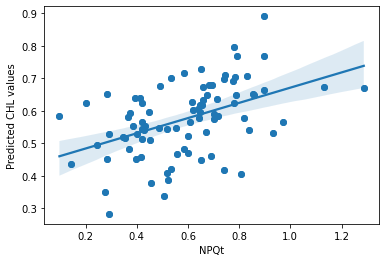

In [649]:
plt.scatter(y_test, y_pred)
plt.ylabel('Predicted CHL values')
plt.xlabel('Ground truth LWC measurements')
sns.regplot(x = y_test , y = y_pred)

In [650]:
from scipy.stats import pearsonr, spearmanr
y_pred2 = [x[0] for x in y_pred]

r, p = spearmanr(y_test, y_pred2)
r2 = r**2
print(r2, p)

0.2334697674792474 2.4510936556343803e-06
